#  Banknote Authentication

Dataset source: [Banknote Authentication UCI](https://archive.ics.uci.edu/dataset/267/banknote+authentication)

Features:                                            
variance - variance of Wavelet Transformed image	                                                   
skewness - skewness of Wavelet Transformed image	                                      
curtosis - curtosis of Wavelet Transformed image		                                                
entropy - entropy of image

Target:                                
class - 0 Fake, 1 Authentic

In [ ]:
!pip install ucimlrepo

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.datasets import make_classification

banknote_authentication = fetch_ucirepo(id=267)

X = banknote_authentication.data.features
y = banknote_authentication.data.targets

df = banknote_authentication.data.original

Data analysis

In [ ]:
X = np.array(X)
y = np.array(y.iloc[:,0])
print(df.isnull().sum())

variance    0
skewness    0
curtosis    0
entropy     0
class       0
dtype: int64


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1372 entries, 0 to 1371
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   variance  1372 non-null   float64
 1   skewness  1372 non-null   float64
 2   curtosis  1372 non-null   float64
 3   entropy   1372 non-null   float64
 4   class     1372 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 53.7 KB


In [ ]:
print(df.shape)
df.head(6)

(1372, 5)


,variance,skewness,curtosis,entropy,class
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0
5,4.36840,9.6718,-3.9606,-3.16250,0


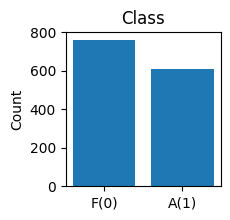

In [ ]:
y_counts = df['class'].value_counts()

plt.figure(figsize=(2, 2))
plt.bar(y_counts.index, y_counts.values)
plt.xticks([0, 1], ['F(0)', 'A(1)'])
plt.ylabel('Count')
plt.title('Class')
plt.show()

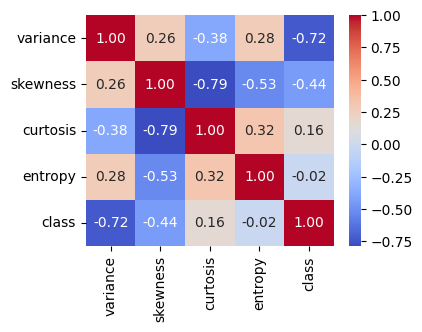

In [ ]:
corr_matrix = df.corr()

plt.figure(figsize=(4,3))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.show()

Linearity analysis

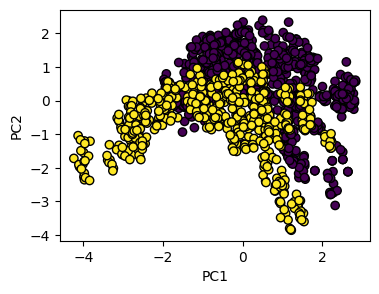

In [ ]:
from sklearn.decomposition import PCA

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(4,3))
scatter = plt.scatter(X_pca[:,0], X_pca[:,1], c=y, edgecolor="k")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

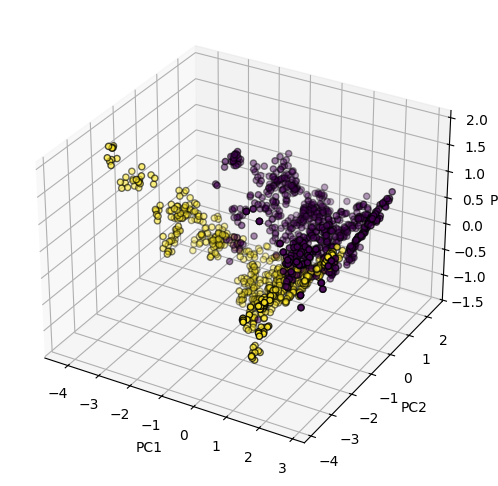

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_pca[:,0], X_pca[:,1], X_pca[:,2], c=y, edgecolor="k")

ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
plt.show()


In [ ]:
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score

def analyze_linearity(X, y):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    print("Linear regression:")
    lin_reg = LinearRegression()
    lin_reg.fit(X_train, y_train)
    y_pred_multi = lin_reg.predict(X_test)

    mse_multi = mean_squared_error(y_test, y_pred_multi)
    r2_multi = r2_score(y_test, y_pred_multi)
    print(f"MSE = {mse_multi:.4f}, R² = {r2_multi:.4f}")

    print("Logistic regression:")
    log_reg = LogisticRegression(random_state=42)
    log_reg.fit(X_train, y_train)
    y_pred_log = log_reg.predict(X_test)

    accuracy_log = accuracy_score(y_test, y_pred_log)
    print(f"Accuracy: {accuracy_log:.4f}")
    print(classification_report(y_test, y_pred_log))

In [ ]:
analyze_linearity(X, y)

Linear regression:
MSE = 0.0333, R² = 0.8651
Logistic regression:
Accuracy: 0.9855
              precision    recall  f1-score   support

           0       1.00      0.97      0.99       153
           1       0.97      1.00      0.98       122

    accuracy                           0.99       275
   macro avg       0.98      0.99      0.99       275
weighted avg       0.99      0.99      0.99       275



Training SVM model with best hyperparameters (GridSearch)

In [ ]:
def train_svc_models(X, y, n_splits=5):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    kernels = ['linear', 'poly', 'rbf', 'sigmoid']
    cv_acc = {}
    best_params = {}

    fig, axes = plt.subplots(2, 2, figsize=(5, 4))
    axes = axes.ravel()

    for i, kernel in enumerate(kernels):
        if kernel == 'linear':
            param_grid = {'C': [0.01, 0.1, 1, 10, 100]}
        elif kernel == 'poly':
            param_grid = {
                'C': [0.01, 0.1, 1, 10],
                'gamma': ['scale', 0.01, 0.1, 1],
                'degree': [2, 3, 4]
            }
        else:
            param_grid = {
                'C': [0.01, 0.1, 1, 10, 100],
                'gamma': ['scale', 0.01, 0.1, 1]
            }

        grid = GridSearchCV(SVC(kernel=kernel, random_state=42), param_grid, cv=n_splits, scoring='accuracy')
        grid.fit(X_scaled, y)

        best_params[kernel] = grid.best_params_
        best_model = grid.best_estimator_

        y_pred_cv = cross_val_predict(best_model, X_scaled, y, cv=n_splits)
        accuracy_mean = accuracy_score(y, y_pred_cv)
        cv_acc[kernel] = accuracy_mean

        print(f"{kernel}: {accuracy_mean:.4f}, ({best_params[kernel]})")

        cm = confusion_matrix(y, y_pred_cv)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i])
        axes[i].set_title(f"{kernel} (Acc: {accuracy_mean:.2f})")
        axes[i].set_ylabel('True')
        axes[i].set_xlabel('Predicted')

    plt.tight_layout()
    plt.show()

linear: 0.9891, ({'C': 10})
poly: 0.9993, ({'C': 1, 'degree': 3, 'gamma': 1})
rbf: 1.0000, ({'C': 1, 'gamma': 'scale'})
sigmoid: 0.9825, ({'C': 10, 'gamma': 0.01})


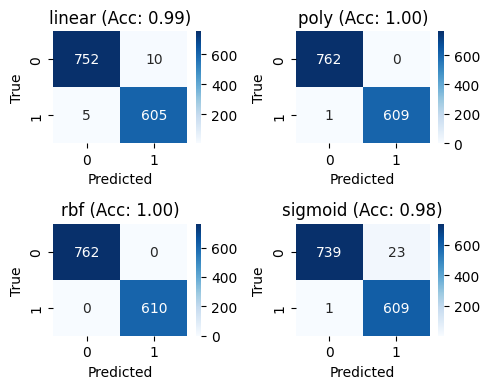

In [ ]:
train_svc_models(X, y)

Polynomial feature expansion

In [ ]:
def create_polynomial_features(X, degree=2):
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    X_poly = poly.fit_transform(X)

    print(f"Poly degree: {degree}")
    print(f"Features num: {X_poly.shape[1]}")
    print()
    return X_poly

Poly degree: 2
Features num: 14

linear: 1.0000, ({'C': 1})
poly: 1.0000, ({'C': 0.1, 'degree': 2, 'gamma': 1})
rbf: 1.0000, ({'C': 1, 'gamma': 1})
sigmoid: 0.9694, ({'C': 1, 'gamma': 0.01})


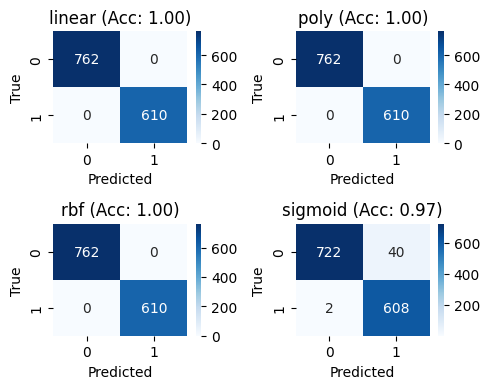

In [ ]:
X_poly = create_polynomial_features(X, degree=2)
train_svc_models(X_poly, y)

Poly degree: 3
Features num: 34

linear: 1.0000, ({'C': 1})
poly: 1.0000, ({'C': 0.1, 'degree': 2, 'gamma': 1})
rbf: 1.0000, ({'C': 10, 'gamma': 'scale'})
sigmoid: 0.9628, ({'C': 1, 'gamma': 0.01})


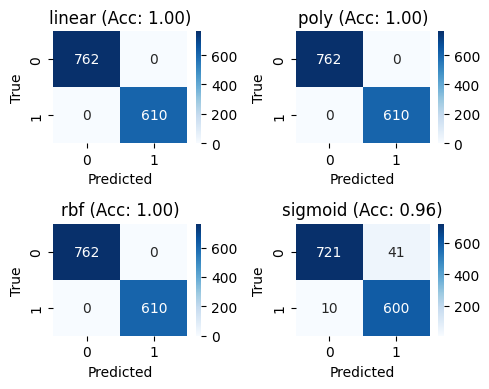

In [ ]:
X_poly = create_polynomial_features(X, degree=3)
train_svc_models(X_poly, y)

# Rock & Mines

Dataset source: [Connectionist Bench (Sonar, Mines vs. Rocks) UCI](https://archive.ics.uci.edu/dataset/151/connectionist+bench+sonar+mines+vs+rocks)

The dataset contains sonar signals reflected from metal cylinders ("mines") and rocks, each represented by 60 numerical features corresponding to energy in different frequency bands.

Target:                                
class - 'M' Mines, 'R' Rock

In [ ]:
!pip install ucimlrepo

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.datasets import make_classification
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso


rock_mines = fetch_ucirepo(id=151)

X = rock_mines.data.features
y = rock_mines.data.targets

df = rock_mines.data.original

Data analysis

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 208 entries, 0 to 207
Data columns (total 61 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Attribute1   208 non-null    float64
 1   Attribute2   208 non-null    float64
 2   Attribute3   208 non-null    float64
 3   Attribute4   208 non-null    float64
 4   Attribute5   208 non-null    float64
 5   Attribute6   208 non-null    float64
 6   Attribute7   208 non-null    float64
 7   Attribute8   208 non-null    float64
 8   Attribute9   208 non-null    float64
 9   Attribute10  208 non-null    float64
 10  Attribute11  208 non-null    float64
 11  Attribute12  208 non-null    float64
 12  Attribute13  208 non-null    float64
 13  Attribute14  208 non-null    float64
 14  Attribute15  208 non-null    float64
 15  Attribute16  208 non-null    float64
 16  Attribute17  208 non-null    float64
 17  Attribute18  208 non-null    float64
 18  Attribute19  208 non-null    float64
 19  Attribut

In [ ]:
print(df.shape)
df.head(6)

(208, 61)


,Attribute1,Attribute2,Attribute3,Attribute4,Attribute5,Attribute6,Attribute7,Attribute8,Attribute9,Attribute10,...,Attribute52,Attribute53,Attribute54,Attribute55,Attribute56,Attribute57,Attribute58,Attribute59,Attribute60,class
0,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,...,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032,R
1,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,...,0.0084,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044,R
2,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,...,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078,R
3,0.0100,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,...,0.0121,0.0036,0.0150,0.0085,0.0073,0.0050,0.0044,0.0040,0.0117,R
4,0.0762,0.0666,0.0481,0.0394,0.0590,0.0649,0.1209,0.2467,0.3564,0.4459,...,0.0031,0.0054,0.0105,0.0110,0.0015,0.0072,0.0048,0.0107,0.0094,R
5,0.0286,0.0453,0.0277,0.0174,0.0384,0.0990,0.1201,0.1833,0.2105,0.3039,...,0.0045,0.0014,0.0038,0.0013,0.0089,0.0057,0.0027,0.0051,0.0062,R


In [ ]:
unique_values = df['class'].unique()
print(unique_values)

['R' 'M']


In [ ]:
df['class'] = df['class'].map({'M': 0, 'R': 1})
y = y.iloc[:, 0].map({'M': 0, 'R': 1})

In [ ]:
X = np.array(X)
y = np.array(y)
print(df.isnull().sum().sum())

0


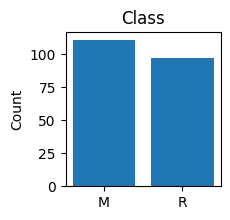

In [ ]:
y_counts = df['class'].value_counts()

plt.figure(figsize=(2, 2))
plt.bar(y_counts.index, y_counts.values)
plt.xticks([0, 1], ['M', 'R'])
plt.ylabel('Count')
plt.title('Class')
plt.show()

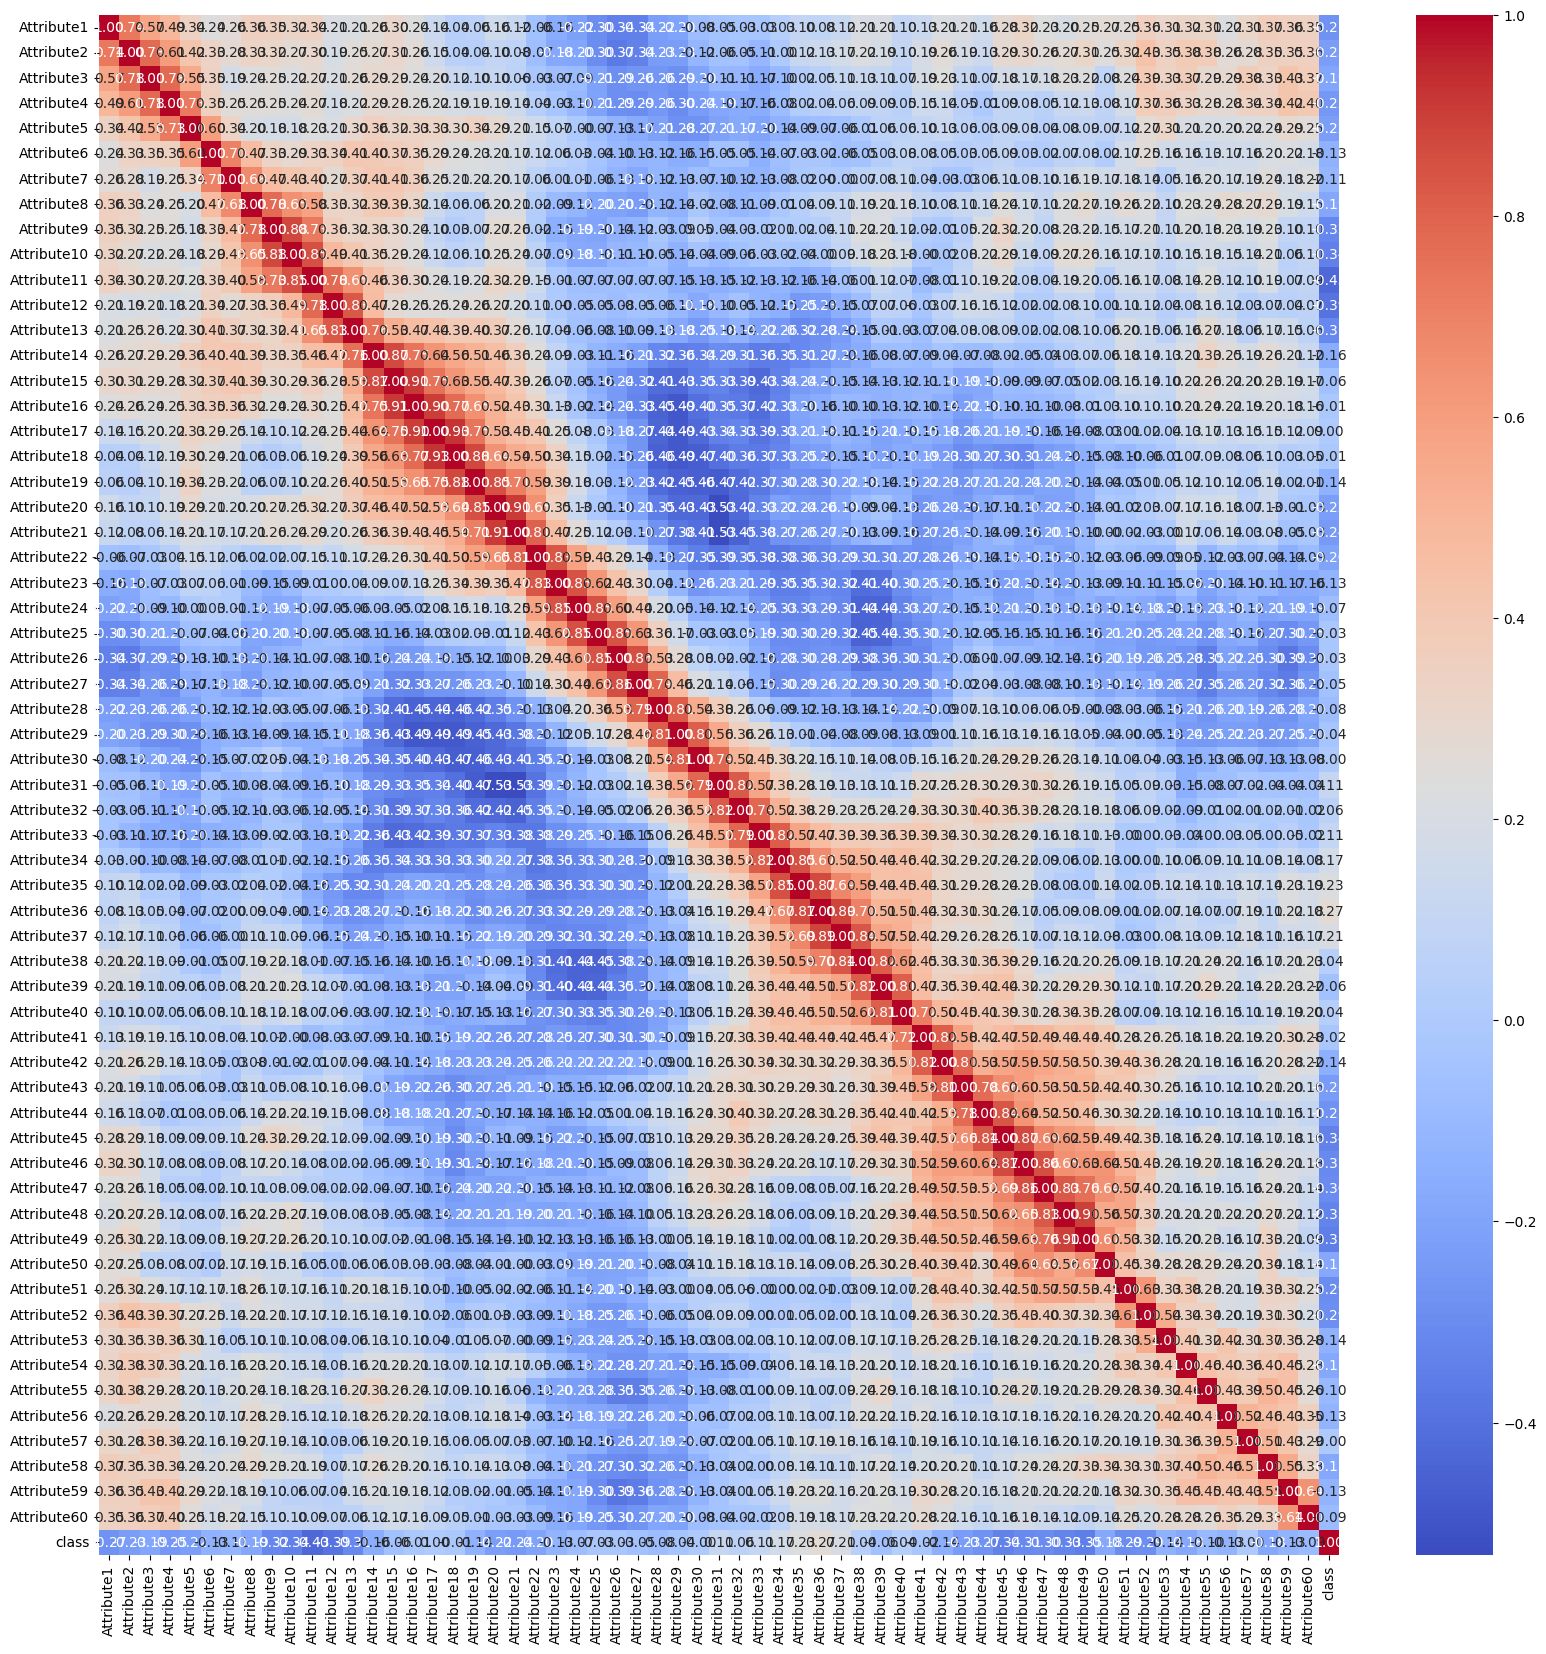

In [ ]:
corr_matrix = df.corr()

plt.figure(figsize=(20,20))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.show()

Linearity analysis

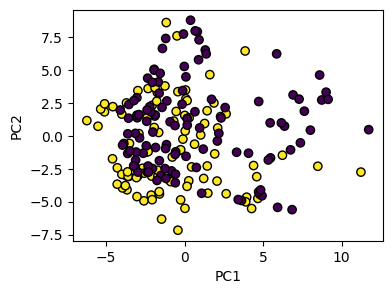

In [ ]:
from sklearn.decomposition import PCA

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(4,3))
scatter = plt.scatter(X_pca[:,0], X_pca[:,1], c=y, edgecolor="k")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

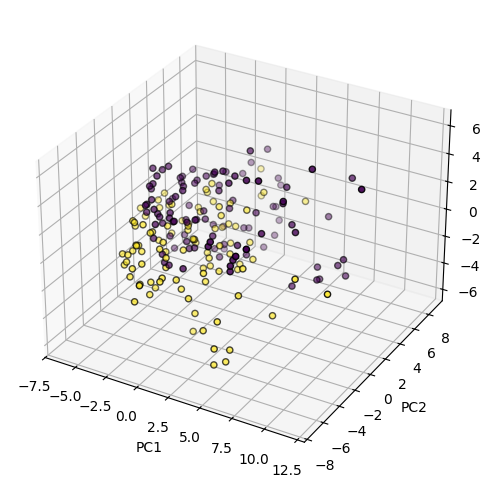

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_pca[:,0], X_pca[:,1], X_pca[:,2], c=y, edgecolor="k")

ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
plt.show()


In [ ]:
def analyze_linearity_reg(X, y, alpha=0, C=1):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=0, stratify=y
    )

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    print("Linear regression:")
    lin_reg = Lasso(alpha=alpha, random_state=42)
    lin_reg.fit(X_train_scaled, y_train)
    y_pred_multi = lin_reg.predict(X_test_scaled)

    mse_multi = mean_squared_error(y_test, y_pred_multi)
    r2_multi = r2_score(y_test, y_pred_multi)
    print(f"MSE = {mse_multi:.4f}, R² = {r2_multi:.4f}")

    print("\nLogistic regression:")
    log_reg = LogisticRegression(C=C, penalty='l1', solver='liblinear', random_state=42)
    log_reg.fit(X_train_scaled, y_train)
    y_pred_log = log_reg.predict(X_test_scaled)

    accuracy_log = accuracy_score(y_test, y_pred_log)
    print(f"Accuracy: {accuracy_log:.4f}")

In [ ]:
analyze_linearity_reg(X, y, alpha=0.04, C=1)

Linear regression:
MSE = 0.1893, R² = 0.2412

Logistic regression:
Accuracy: 0.7381


Training SVM model with best hyperparameters (GridSearch)

linear: 0.6587, ({'C': 0.01})
poly: 0.6635, ({'C': 0.01, 'degree': 3, 'gamma': 1})
rbf: 0.6394, ({'C': 1, 'gamma': 'scale'})
sigmoid: 0.6731, ({'C': 0.1, 'gamma': 0.1})


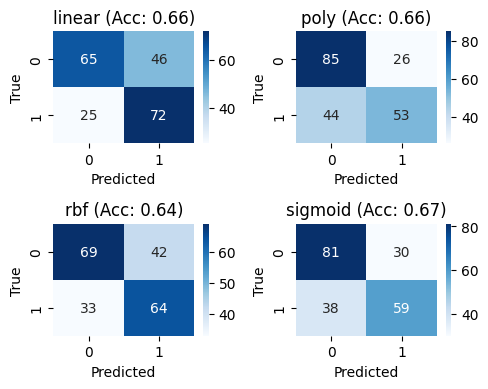

In [ ]:
train_svc_models(X, y)

Training SVM with data augmentation

In [ ]:
def augment_data(X, y, multiplier=2):
    X_augmented = [X]
    y_augmented = [y]

    for i in range(multiplier - 1):
        noise = np.random.normal(0, 0.0005, X.shape)
        X_noisy = X + noise

        X_augmented.append(X_noisy)
        y_augmented.append(y)

    X_combined = np.vstack(X_augmented)
    y_combined = np.hstack(y_augmented)
    return X_combined, y_combined

In [ ]:
def cv_split(n_samples, n_splits=5, random_state=None):
    indices = np.arange(n_samples)
    rg = np.random.default_rng(seed=random_state)
    rg.shuffle(indices)

    fold_sizes = np.full(n_splits, n_samples // n_splits, dtype=int)
    fold_sizes[:n_samples % n_splits] += 1

    current = 0
    for fold_size in fold_sizes:
        test_idx = indices[current:current+fold_size]
        train_idx = np.concatenate((indices[:current], indices[current+fold_size:]))
        yield train_idx, test_idx
        current += fold_size

In [ ]:
def train_svc_models_aug(X, y, n_splits=5):
    kernels = ['linear', 'poly', 'rbf', 'sigmoid']
    cv_acc = {}
    best_params = {}
    best_models = {}

    fig, axes = plt.subplots(2, 2, figsize=(5, 4))
    axes = axes.ravel()

    print("Accuracy:")
    for i, kernel in enumerate(kernels):
        if kernel == 'linear':
            param_grid = {'C': [0.01, 0.1, 1, 10, 100]}
        elif kernel == 'poly':
            param_grid = {
                'C': [0.01, 0.1, 1, 10],
                'gamma': ['scale', 0.01, 0.1, 1],
                'degree': [2, 3, 4]
            }
        else:
            param_grid = {
                'C': [0.01, 0.1, 1, 10, 100],
                'gamma': ['scale', 0.01, 0.1, 1]
            }

        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        X_aug, y_aug = augment_data(X_scaled, y, multiplier=3)

        grid = GridSearchCV(SVC(kernel=kernel, random_state=42), param_grid, cv=n_splits, scoring='accuracy')
        grid.fit(X_aug, y_aug)

        best_params[kernel] = grid.best_params_
        best_model = grid.best_estimator_

        fold_scores = []
        y_pred_all = np.zeros_like(y)

        for train_idx, test_idx in cv_split(len(X), n_splits=n_splits, random_state=42):
            X_train, X_test = X[train_idx], X[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]

            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.transform(X_test)

            X_train_aug, y_train_aug = augment_data(X_train_scaled, y_train, multiplier=3)

            best_model.fit(X_train_aug, y_train_aug)
            y_pred = best_model.predict(X_test_scaled)

            fold_scores.append(accuracy_score(y_test, y_pred))
            y_pred_all[test_idx] = y_pred

        accuracy_mean = np.mean(fold_scores)
        cv_acc[kernel] = fold_scores

        print(f"{kernel}: {accuracy_mean:.4f}, ({best_params[kernel]})")

        cm = confusion_matrix(y, y_pred_all)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i])
        axes[i].set_title(kernel)
        axes[i].set_ylabel('True')
        axes[i].set_xlabel('Predicted')

    plt.tight_layout()
    plt.show()

    print("\nCross-validation scores:")
    for kernel in kernels:
        print(f"{kernel}: {cv_acc[kernel]}")


Accuracy:
linear: 0.7362, ({'C': 100})
poly: 0.7554, ({'C': 0.01, 'degree': 2, 'gamma': 1})
rbf: 0.8797, ({'C': 1, 'gamma': 'scale'})
sigmoid: 0.7547, ({'C': 10, 'gamma': 0.01})


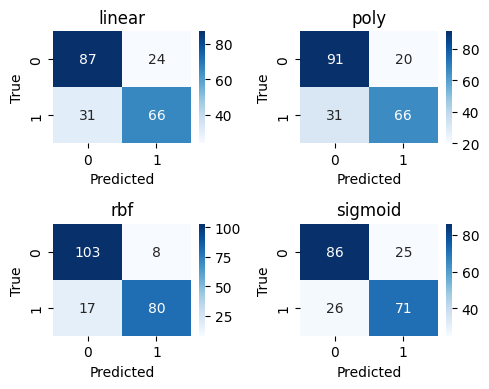


Cross-validation scores:
linear: [0.7619047619047619, 0.6428571428571429, 0.6666666666666666, 0.8536585365853658, 0.7560975609756098]
poly: [0.7619047619047619, 0.7142857142857143, 0.6666666666666666, 0.8780487804878049, 0.7560975609756098]
rbf: [0.8333333333333334, 0.8571428571428571, 0.9761904761904762, 0.9024390243902439, 0.8292682926829268]
sigmoid: [0.8095238095238095, 0.6666666666666666, 0.8095238095238095, 0.8292682926829268, 0.6585365853658537]


In [ ]:
train_svc_models_aug(X, y)